# Overstable Librations
In this tutorial, we'll use the `PlanarResonanceEquations` class from `celmech.numerical_resonance_models` to explore the phenomenon of overstable librations 
(see, e.g.,  [Meyer & Wisdom (2008)](https://ui.adsabs.harvard.edu/abs/2008Icar..193..213M/abstract),
[Goldreich & Schlicting (2014)](https://ui.adsabs.harvard.edu/abs/2014AJ....147...32G/abstract),
[Deck & Batygin (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...810..119D/abstract),
[Hadden & Payne (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....160..106H/abstract)
). 

This is a dynamical instability that can occur when planets are captured smoothly into a resonance under dissipative forces, usually taken to be of the form
\begin{align}
\frac{de_i}{dt} &= -\frac{1}{\tau_{e_i}}e_i \\
\frac{da_i}{dt} &= -\frac{1}{\tau_{a_i}}a_i - 2p\frac{e_i^2}{\tau_{e_i}}
\end{align}
with $\tau_{e_i} = \tau_{a_i}/K_i$ and the parameter $p=1$ for eccentricity dissipation at constant angular momentum (e.g., as in the case of tides).

In this example, we'll look at the equilibrium resonant configurations of pairs of planets for different values of $K_i$ and examine when these equilibria are susceptible to the overstable libration instability.


In [1]:
import numpy as np
import rebound as rb
from celmech.numerical_resonance_models import PlanarResonanceEquations
import matplotlib.pyplot as plt
%matplotlib inline

Start by initializing a `PlanarResonanceEquations` object (note that this can take a little while)

In [2]:
# Note: n_quad_pts has been set higher than the default. 
# This is sometimes neccessary in order to get correct results at 
# large eccentricities. 
res_eqs = PlanarResonanceEquations(2,1,n_quad_pts=51)

Set planet masses and migration parameters.  `PlanarResonanceEquations.tau_alpha` sets the value of 
\begin{equation}
\tau_\alpha^{-1} = \tau_{a_2}^{-1} - \tau_{a_1}^{-1}
\end{equation}
Provided this timescale is sufficiently long compared to the libration period, it does not effect whether the instability occurs and the timescale over which the instability occurs is simply propotional to $\tau_\alpha$.
`PlanarResonanceEquations.K1`, `PlanarResonanceEquations.K2`, and `PlanarResonanceEquations.p` set the values of $K_1,K_2,$ and $p$ in the equations above. Note that the instability requires $p\ne 0$. Below, we will always take $K_1=K_2$.

In [3]:
res_eqs.m1 = 1e-4
res_eqs.m2 = 1.5e-4
res_eqs.tau_alpha = 3e5
res_eqs.p = 1
def set_Kvals(res_eqs,K):
    res_eqs.K1=K
    res_eqs.K2=K

Here we will solve for the resoant equilibrium configurations for different values of $K_1=K_2=K$, looping over values of $K$.

In [4]:
NK = 250
Kvals = np.logspace(3,0.25,NK)
eq_vars = np.zeros((NK,5))

# Get initial equilibrium
set_Kvals(res_eqs,Kvals[0])
guess_els = {'a1':res_eqs.alpha,'a2':1,'e1':0.01,'e2':0.001,'theta1':0.,'theta2':np.pi}
guess = res_eqs.orbital_elements_to_dyvars(guess_els)
y = res_eqs.find_equilibrium(guess,dissipation=True,max_iter=50)

for i,K in enumerate(Kvals):
    set_Kvals(res_eqs,K)
    y = res_eqs.find_equilibrium(y,dissipation=True,max_iter=25)
    eq_vars[i] = y

Now we'll convert from dynamical variables to orbital elements and determine the stability of the various equilibria.  The stability of a given equilibrium point is determined by the Jacobian of the equations of motion evaluated at that equilibrium point. 

Below, the Jacobian is evaluated with the `PlanarResonanceEquations.flow_jac` and then the eigenvalues of the equations are computed with `numpy.linalg.eigvals`.  

The Jacobian will have two eigenvalue pairs of the form $\pm i\omega_j + \rho_j$ where the $\omega_j$ are approximately the oscillation frequencies of the resonance in the dissipation-free limit and $|\rho_j| \sim 1/\tau_\alpha$. Instability occurs whenever one of the $\rho_j>0$, leading to exponential growth of one of the oscillation modes.

In [5]:
e1,e2,Delta = np.zeros((3,NK))
eig_max = np.zeros(NK)
for i,K in enumerate(Kvals):
    set_Kvals(res_eqs,K)
    els = res_eqs.dyvars_to_orbital_elements(eq_vars[i])
    e1[i]=els['e1']
    e2[i]=els['e2']
    a1=els['a1']
    a2=els['a2']
    pratio = (a2/a1)**(1.5)
    Delta[i] = (res_eqs.j - res_eqs.k) * pratio / res_eqs.j - 1
    
    # Caluculate Jacobian
    J = res_eqs.flow_jac(eq_vars[i])
    
    # Calculate eigenvalues
    eigs = np.linalg.eigvals(J)
    
    # Store the maximum real part of the eigenvalues
    eig_max[i] = np.max(np.real(eigs))

Now we'll plot our results on the stability of the equilibria under the effects of our dissipative forces.

We'll also initialize a `rebound.Simulation` object to simulate the overstability, using `PlanarResonanceEquations.dyvars_to_rebound_simulation` with the keyword argument `include_dissipation=True` in order to add migration and eccentricity damping effects through the `reboundx` module.

0.3828681765215852


Text(0, 0.5, '$e_2$')

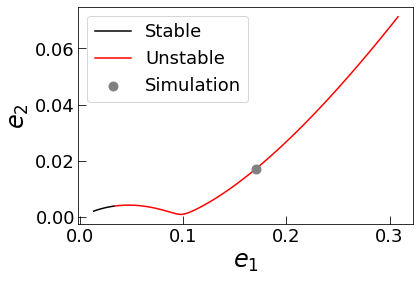

In [6]:
stable_mask = eig_max<0
plt.plot(e1[stable_mask],e2[stable_mask],color='k',label="Stable")
unstable_mask = eig_max>0
plt.plot(e1[unstable_mask],e2[unstable_mask],color='r',label="Unstable")

# Select and example equilibrium and initialize a simulation there
I = np.argmax(eig_max) + 100
inst_time = 1 / eig_max[I]
print(inst_time/res_eqs.tau_alpha)
Kexample = Kvals[I]
set_Kvals(res_eqs,Kexample)
dyvars  = eq_vars[I]
sim,extras = res_eqs.dyvars_to_rebound_simulation(dyvars,include_dissipation=True,osculating_correction=False)
els_eq = res_eqs.dyvars_to_orbital_elements(dyvars)
plt.scatter(els_eq['e1'],els_eq['e2'],color='gray',zorder=99,s=80,label="Simulation")

plt.legend(fontsize=18)
plt.tick_params(direction='in',labelsize=18,size=8)
plt.xlabel(r"$e_1$",fontsize=24)
plt.ylabel(r"$e_2$",fontsize=24)

Run the `rebound` simulation and read in the results.

In [7]:
from celmech.nbody_simulation_utilities import set_timestep, get_simarchive_integration_results
Tfin = 1.85 * res_eqs.tau_alpha
Nout = 500
sim.integrator='whfast'
set_timestep(sim,1/50.)
sim.automateSimulationArchive("overstable_libration.sa",Tfin/Nout,deletefile=True)
sim.integrate(Tfin)
nbresults = get_simarchive_integration_results("overstable_libration.sa")

/Users/shadden/anaconda/lib/python3.6/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Plot the evolution of the system. The libration overstability is illustrated by the growing amplitude of oscillations in the planets' period ratio and resonant angles. At the end of the simulation, the system escapes the resonance.

/Users/shadden/anaconda/lib/python3.6/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


(-180, 180)

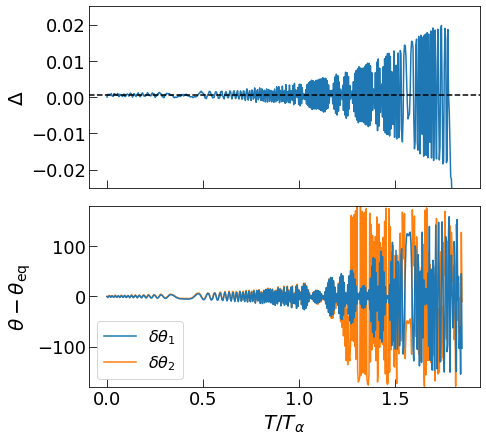

In [8]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(7,7))
plt.subplots_adjust(hspace=0.1)
nbresults = get_simarchive_integration_results("overstable_libration.sa")
Delta = (res_eqs.j - res_eqs.k) * nbresults['P'][1]/nbresults['P'][0] / res_eqs.j - 1
phi = np.array([(res_eqs.k-res_eqs.j) , res_eqs.j]) @ nbresults['l']
theta = phi - nbresults['pomega']
theta = np.mod(theta,2*np.pi)
xcoord=nbresults['time']/res_eqs.tau_alpha

# Delta
ax[0].plot(xcoord,Delta)
ax[0].set_ylabel(r"$\Delta$",fontsize=20)

# Equilibrium Delta
Delta_eq = (res_eqs.j - res_eqs.k) * (els_eq['a2']/els_eq['a1'])**(1.5)/res_eqs.j  - 1 
ax[0].axhline(Delta_eq,ls='--',color='k')


### Angles
to_deg = 180 / np.pi

#dtheta1
ycoord = np.mod(theta[0]-els_eq['theta1'] + np.pi,2*np.pi)-np.pi
ycoord *= to_deg
ax[1].plot(xcoord,ycoord,label=r"$\delta\theta_1$",zorder=99)

#dtheta2
ycoord =np.mod(theta[1]-els_eq['theta2'] + np.pi,2*np.pi)-np.pi
ycoord *= to_deg
ax[1].plot(xcoord,ycoord,label=r"$\delta\theta_2$")


# Labels, legends, etc
ax[1].set_xlabel(r"$T/T_\alpha$",fontsize=20)
ax[1].set_ylabel(r"$\theta-\theta_\mathrm{eq}$",fontsize=20)
ax[1].legend(fontsize=16,loc='lower left')
for a in ax:
    plt.sca(a)
    plt.tick_params(direction='in',labelsize=18,size=8)

ax[0].set_ylim(-0.025,0.025)
ax[1].set_ylim(-180,180)